In [1]:
import os,sys
curr_path = os.getcwd()
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
from memory import ReplayBuffer,NaivePrioritizedBuffer,NStepReplayBuffer
from common.plot import plot_rewards
from common.utils import save_results,make_dir

# multi-envs + 1 agent

In [2]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
import tianshou as ts
# from common.multiprocessing_env import SubprocVecEnv

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# !pip install box2d-py # for box2d envs
def make_env(env_id,seed=1):
    if 'Pong' in env_id:
        env = make_atari(env_id)
        env = wrap_deepmind(env,episode_life=True)
        env = wrap_pytorch(env) 
    else:
        env = gym.make(env_id)
    if seed: env.seed(seed)
    return env
def init_envs_agent(cfg,nenv,seed=1):
    envs = ts.env.ShmemVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
#     envs = ts.env.SubprocVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
    if len(envs.observation_space[0].shape) == 1:
        state_dim = envs.observation_space[0].shape[0]
    else:
        state_dim = envs.observation_space[0].shape
        
    if 'Continuous' in cfg.model:
        cfg.max_act = envs.action_space[0].high[0]
        action_dim = envs.action_space[0].shape[0]
    else:
        action_dim = envs.action_space[0].n
        
    agent = Agent(state_dim,action_dim,cfg)
    return envs,agent
    
#<ImageToPyTorch<ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>

In [4]:
### slower than ts.env.SubprocVectorEnv ###
# from common.multiprocessing_env import SubprocVecEnv
# def make_env(env_name,seed=1):
#     env = make_atari(env_name)
#     env = wrap_deepmind(env,episode_life=False)
#     env = wrap_pytorch(env) 
#     return env
# def init_envs_agent(cfg,nenv,seed=1):
#     envs = SubprocVecEnv([lambda:make_env(cfg.env_id) for i in range(nenv)])
#     state_dim = envs.observation_space.shape
#     action_dim = envs.action_space.n
#     agent = Agent(state_dim,action_dim,cfg)
#     return envs,agent

In [32]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)
    
    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
#     memorys = [NStepReplayBuffer(cfg.n_multi_step,cfg.gamma, ReplayBuffer(cfg.memory_size)) 
#                 for _ in range(cfg.n_train_env)]
    memorys = [ReplayBuffer(cfg.memory_size) for _ in range(cfg.n_train_env)]

    states = envs.reset()
    while i_frame < cfg.max_train_frames: #1500000: #
        ### interactive with environments ###
        actions = agent.sample(states)
        if cfg.n_train_env == 1: actions = [actions]
    #     actions = np.random.randint(6,size=cfg.n_train_env)
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        for memory,s,a,r,next_s,done in zip(memorys, states, actions, rewards, next_states, dones):
            memory.push(s,a,r,next_s,done)
        states = next_states
        i_frame += len(actions)
        ### updating agent ###
        if all([len(memory)>cfg.memory_warmup_size for memory in memorys]) and i_frame%cfg.learn_freq==0:
            batch_state,batch_action,batch_reward,batch_next_state,batch_done = [],[],[],[],[]
            sample_ids = np.random.choice(cfg.n_train_env,cfg.batch_size,p=[1/cfg.n_train_env]*cfg.n_train_env)
            sample_num = np.bincount(sample_ids, minlength=cfg.n_train_env)
            sample_num[sample_num==0] = 4
            for i,n in enumerate(sample_num):
                s,a,r,ns,d = memorys[i].sample(n)
                for batch, x in zip([batch_state,batch_action,batch_reward,batch_next_state,batch_done],
                                    [s,a,r,ns,d]):
                    batch.append(x)
            batch_state,batch_action,batch_reward,batch_next_state,batch_done = map(
                lambda x:np.concatenate(x),[batch_state,batch_action,batch_reward,batch_next_state,batch_done])
            loss = agent.learn(batch_state,batch_action,batch_reward,batch_next_state,batch_done)
            if loss:
                history['loss'].append(loss)
            elif history['loss']:
                history['loss'].append(history['loss'][-1])
        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
    #         print(history,done_envs_ids,eps_rewards)aa
    #         break
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

In [6]:
def evaluate(cfg,envs,agent,render=False):
    envs.seed(1)
    print('Start Evaluating!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames']  = [],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_eval_env),np.zeros(cfg.n_eval_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0

    states = envs.reset()
    while i_frame < cfg.max_eval_frames:
        ### interactive with environments ###
        if render: envs.render()
        actions = agent.predict(states).cpu().numpy()
        if cfg.n_eval_env == 1: actions = [actions]
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        states = next_states
        i_frame += len(actions)

        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
            
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 10:
                prev_frame_verbose = history['frames'][-1]
                print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
    return history

In [7]:
def main():
    cfg = config()
    print(cfg.agent,cfg.env_id)
    
    envs,agent = init_envs_agent(cfg,cfg.n_train_env)
    history = train(cfg,envs,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(history,tag='train',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    eval_envs,agent = init_envs_agent(cfg,cfg.n_eval_env,seed=10)
    agent.load(path=cfg.model_path)
    history = evaluate(cfg,eval_envs,agent,render=False)
    save_results(history,tag='eval',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

# Pendulum-v0

In [15]:
class config:
    def __init__(self):
        self.seed = 1                    # seed
        self.agent = 'TD3'              # name of agent
        self.env_id = 'Pendulum-v0'     # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4             # number of evaluation environment 
        self.max_train_frames = 4e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 600   # number of experience stored in memory before learning
        self.learn_freq = 2             # number of steps for one learning 
        self.batch_size = 512           # number of examples in one batch
        self.policy_noise_std = 0.2     # std of Gaussian noise added to target policy during updating critic 
        self.policy_noise_clip = 0.5    # range to clip target policy noise
        self.learn_policy_freq = 2      # frequency of delayed policy updates
        self.soft_tau = 0.01            # parm for soft updating target model
        self.actor_lr = 0.0001          # learning rate of policy opt
        self.critic_lr = 0.0001         # learning rate of value opt
        self.gamma = 0.90               # discount rate of reward
        self.epsilon_start = 0.90       # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/2500     # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'Continuous'       # name or type of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 2.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

TD3 Pendulum-v0
Start Training!
20210827-202534
[20210827-202534: TD3] Episode:16: Frame:3200.0: Reward:-1765.9
[20210827-202535: TD3] Episode:32: Frame:6400.0: Reward:-1318.4
[20210827-202535: TD3] Episode:48: Frame:9600.0: Reward:-1138.8
[20210827-202539: TD3] Episode:64: Frame:12800.0: Reward:-1244.4: Loss:15.1858
[20210827-202543: TD3] Episode:80: Frame:16000.0: Reward:-1288.0: Loss:14.8593
[20210827-202547: TD3] Episode:96: Frame:19200.0: Reward:-1574.4: Loss:18.4513
[20210827-202551: TD3] Episode:112: Frame:22400.0: Reward:-1740.7: Loss:24.5581
[20210827-202555: TD3] Episode:128: Frame:25600.0: Reward:-1749.3: Loss:28.0538
[20210827-202600: TD3] Episode:144: Frame:28800.0: Reward:-1868.1: Loss:33.6453
[20210827-202604: TD3] Episode:160: Frame:32000.0: Reward:-1745.0: Loss:37.9548
[20210827-202608: TD3] Episode:176: Frame:35200.0: Reward:-1874.6: Loss:44.2655
[20210827-202613: TD3] Episode:192: Frame:38400.0: Reward:-1810.4: Loss:44.9425
[20210827-202617: TD3] Episode:208: Frame:4

[20210827-203401: TD3] Episode:1664: Frame:332800.0: Reward:-252.4: Loss:30.6998
[20210827-203407: TD3] Episode:1680: Frame:336000.0: Reward:-368.4: Loss:32.0254
[20210827-203413: TD3] Episode:1696: Frame:339200.0: Reward:-131.0: Loss:28.9327
[20210827-203419: TD3] Episode:1712: Frame:342400.0: Reward:-269.6: Loss:33.8938
[20210827-203425: TD3] Episode:1728: Frame:345600.0: Reward:-249.1: Loss:34.1075
[20210827-203432: TD3] Episode:1744: Frame:348800.0: Reward:-127.4: Loss:30.3898
[20210827-203438: TD3] Episode:1760: Frame:352000.0: Reward:-127.4: Loss:28.6102
[20210827-203444: TD3] Episode:1776: Frame:355200.0: Reward:-129.8: Loss:26.3415
[20210827-203449: TD3] Episode:1792: Frame:358400.0: Reward:-132.0: Loss:29.7949
[20210827-203454: TD3] Episode:1808: Frame:361600.0: Reward:-129.8: Loss:42.2575
[20210827-203457: TD3] Episode:1824: Frame:364800.0: Reward:-130.2: Loss:30.9578
[20210827-203502: TD3] Episode:1840: Frame:368000.0: Reward:-248.9: Loss:27.4501
[20210827-203505: TD3] Episo

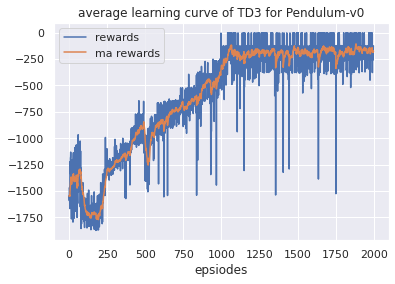

Start Evaluating!
20210827-203602
[20210827-203602: TD3] Episode:4: Frame:800.0: Reward:-127.7
[20210827-203603: TD3] Episode:8: Frame:1600.0: Reward:-133.7
[20210827-203603: TD3] Episode:12: Frame:2400.0: Reward:-132.2
[20210827-203603: TD3] Episode:16: Frame:3200.0: Reward:-129.3
[20210827-203604: TD3] Episode:20: Frame:4000.0: Reward:-137.5
[20210827-203604: TD3] Episode:24: Frame:4800.0: Reward:-127.3
[20210827-203605: TD3] Episode:28: Frame:5600.0: Reward:-249.6
[20210827-203605: TD3] Episode:32: Frame:6400.0: Reward:-0.4
[20210827-203606: TD3] Episode:36: Frame:7200.0: Reward:-132.5
[20210827-203606: TD3] Episode:40: Frame:8000.0: Reward:-0.0
[20210827-203606: TD3] Episode:44: Frame:8800.0: Reward:-129.7
[20210827-203607: TD3] Episode:48: Frame:9600.0: Reward:-360.0
results saved!


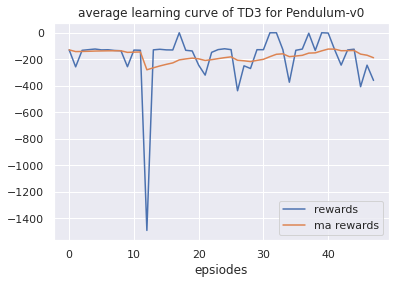

In [12]:
# 0.2, 0.5, 1/2500
main()

# LunarLanderContinuous-v2

In [43]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'TD3'             # name of agent
        self.env_id = 'LunarLanderContinuous-v2'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.4e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 600  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.batch_size = 512          # number of examples in one batch
        self.policy_noise_std = 0.05     # std of Gaussian noise added to target policy during updating critic 
        self.policy_noise_clip = 0.1    # range to clip target policy noise
        self.learn_policy_freq = 2      # frequency of delayed policy updates
        self.soft_tau = 0.02           # parm for soft updating target model
        self.actor_lr = 0.00016         # learning rate of policy opt
        self.critic_lr = 0.00016        # learning rate of value opt
        self.gamma = 0.98              # discount rate of reward
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/2500    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'Continuous'       # name or type of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 1.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

TD3 LunarLanderContinuous-v2
Start Training!
20210828-005615
[20210828-005616: TD3] Episode:1: Frame:68.0: Reward:-287.0
[20210828-005616: TD3] Episode:13: Frame:1162.0: Reward:-112.0
[20210828-005616: TD3] Episode:23: Frame:2249.0: Reward:-85.3
[20210828-005617: TD3] Episode:33: Frame:3295.0: Reward:-387.1
[20210828-005617: TD3] Episode:44: Frame:4503.0: Reward:-538.7
[20210828-005617: TD3] Episode:54: Frame:5583.0: Reward:-386.6
[20210828-005617: TD3] Episode:65: Frame:6681.0: Reward:-173.4
[20210828-005618: TD3] Episode:75: Frame:7734.0: Reward:-119.8
[20210828-005618: TD3] Episode:85: Frame:8772.0: Reward:-186.8
[20210828-005619: TD3] Episode:96: Frame:9782.0: Reward:-358.3: Loss:82.1115
[20210828-005621: TD3] Episode:106: Frame:10845.0: Reward:-128.1: Loss:96.0210
[20210828-005623: TD3] Episode:116: Frame:11924.0: Reward:-260.9: Loss:92.1490
[20210828-005626: TD3] Episode:125: Frame:13031.0: Reward:-47.1: Loss:83.8684
[20210828-005627: TD3] Episode:133: Frame:14092.0: Reward:-103.

[20210828-005837: TD3] Episode:302: Frame:120881.0: Reward:-76.2: Loss:-10.6436
[20210828-005840: TD3] Episode:304: Frame:122881.0: Reward:-45.5: Loss:-12.4698
[20210828-005841: TD3] Episode:305: Frame:123881.0: Reward:-56.2: Loss:-9.4248
[20210828-005842: TD3] Episode:306: Frame:124881.0: Reward:-83.7: Loss:-7.0585
[20210828-005842: TD3] Episode:307: Frame:125881.0: Reward:1.0: Loss:-12.0849
[20210828-005843: TD3] Episode:308: Frame:126881.0: Reward:-48.0: Loss:-8.8876
[20210828-005843: TD3] Episode:309: Frame:127881.0: Reward:-43.5: Loss:-9.0747
[20210828-005844: TD3] Episode:310: Frame:128881.0: Reward:3.0: Loss:-7.5483
[20210828-005845: TD3] Episode:311: Frame:129881.0: Reward:-18.0: Loss:-4.0826
[20210828-005845: TD3] Episode:312: Frame:130881.0: Reward:-63.5: Loss:-8.8317
[20210828-005848: TD3] Episode:313: Frame:131881.0: Reward:-53.1: Loss:6.6160
[20210828-005850: TD3] Episode:314: Frame:132881.0: Reward:-79.2: Loss:-11.0774
[20210828-005851: TD3] Episode:315: Frame:133881.0: R

[20210828-010113: TD3] Episode:417: Frame:235466.0: Reward:38.0: Loss:-6.1066
[20210828-010114: TD3] Episode:418: Frame:236466.0: Reward:88.0: Loss:4.1375
[20210828-010114: TD3] Episode:419: Frame:237466.0: Reward:-93.3: Loss:-4.1042
[20210828-010114: TD3] Episode:420: Frame:238466.0: Reward:-58.1: Loss:-7.1772
[20210828-010116: TD3] Episode:421: Frame:239466.0: Reward:42.3: Loss:-4.5374
[20210828-010116: TD3] Episode:422: Frame:240466.0: Reward:-41.4: Loss:-4.4514
[20210828-010117: TD3] Episode:423: Frame:241466.0: Reward:-55.7: Loss:2.0455
[20210828-010117: TD3] Episode:424: Frame:242466.0: Reward:-65.4: Loss:-5.1470
[20210828-010118: TD3] Episode:425: Frame:243466.0: Reward:-4.5: Loss:15.1313
[20210828-010123: TD3] Episode:426: Frame:244466.0: Reward:-23.6: Loss:-3.8100
[20210828-010123: TD3] Episode:427: Frame:245466.0: Reward:58.5: Loss:-4.6447
[20210828-010124: TD3] Episode:428: Frame:246466.0: Reward:-69.9: Loss:-5.0530
[20210828-010127: TD3] Episode:429: Frame:247466.0: Reward:

[20210828-010352: TD3] Episode:531: Frame:348773.0: Reward:104.9: Loss:-2.0055
[20210828-010352: TD3] Episode:532: Frame:349773.0: Reward:-37.0: Loss:-0.2763
[20210828-010355: TD3] Episode:533: Frame:350773.0: Reward:-16.4: Loss:0.6925
[20210828-010356: TD3] Episode:534: Frame:351773.0: Reward:-30.2: Loss:17.9035
[20210828-010357: TD3] Episode:535: Frame:352773.0: Reward:-87.6: Loss:-1.1263
[20210828-010358: TD3] Episode:536: Frame:353773.0: Reward:-146.4: Loss:-2.1087
[20210828-010358: TD3] Episode:537: Frame:354773.0: Reward:-53.5: Loss:-1.4392
[20210828-010404: TD3] Episode:538: Frame:355773.0: Reward:20.0: Loss:-1.3959
[20210828-010405: TD3] Episode:539: Frame:356773.0: Reward:24.9: Loss:0.2865
[20210828-010405: TD3] Episode:540: Frame:357773.0: Reward:52.7: Loss:1.1706
[20210828-010407: TD3] Episode:542: Frame:359617.0: Reward:72.9: Loss:0.1032
[20210828-010412: TD3] Episode:543: Frame:360617.0: Reward:-56.8: Loss:-0.7641
[20210828-010415: TD3] Episode:544: Frame:361617.0: Reward:

[20210828-010726: TD3] Episode:661: Frame:472034.0: Reward:-83.2: Loss:-0.1874
[20210828-010727: TD3] Episode:662: Frame:473034.0: Reward:33.1: Loss:0.3293
[20210828-010728: TD3] Episode:663: Frame:474034.0: Reward:64.7: Loss:1.4223
[20210828-010730: TD3] Episode:665: Frame:475280.0: Reward:203.1: Loss:4.9590
[20210828-010733: TD3] Episode:667: Frame:476949.0: Reward:34.7: Loss:-0.6918
[20210828-010735: TD3] Episode:669: Frame:478708.0: Reward:43.0: Loss:-1.1569
[20210828-010738: TD3] Episode:670: Frame:479708.0: Reward:-39.4: Loss:0.1157
[20210828-010744: TD3] Episode:672: Frame:481346.0: Reward:-26.6: Loss:1.7657
[20210828-010746: TD3] Episode:673: Frame:482346.0: Reward:49.9: Loss:1.3405
[20210828-010746: TD3] Episode:674: Frame:483346.0: Reward:-36.5: Loss:2.2487
[20210828-010746: TD3] Episode:675: Frame:484346.0: Reward:41.0: Loss:0.2489
[20210828-010747: TD3] Episode:677: Frame:485821.0: Reward:195.0: Loss:0.7853
[20210828-010750: TD3] Episode:679: Frame:487483.0: Reward:-51.5: L

[20210828-011133: TD3] Episode:825: Frame:606410.0: Reward:-35.0: Loss:12.5459
[20210828-011136: TD3] Episode:827: Frame:607613.0: Reward:184.1: Loss:3.4422
[20210828-011139: TD3] Episode:830: Frame:609447.0: Reward:-42.8: Loss:-3.0279
[20210828-011139: TD3] Episode:832: Frame:610508.0: Reward:213.8: Loss:1.0379
[20210828-011140: TD3] Episode:833: Frame:611508.0: Reward:21.1: Loss:3.0096
[20210828-011142: TD3] Episode:836: Frame:613064.0: Reward:177.6: Loss:3.6251
[20210828-011148: TD3] Episode:839: Frame:614459.0: Reward:199.6: Loss:-2.1629
[20210828-011156: TD3] Episode:841: Frame:615917.0: Reward:-47.1: Loss:-4.4740
[20210828-011157: TD3] Episode:843: Frame:617497.0: Reward:8.5: Loss:-3.1014
[20210828-011158: TD3] Episode:846: Frame:619371.0: Reward:175.9: Loss:-3.3974
[20210828-011200: TD3] Episode:848: Frame:620986.0: Reward:37.1: Loss:-3.4149
[20210828-011204: TD3] Episode:850: Frame:622388.0: Reward:165.2: Loss:-3.4190
[20210828-011210: TD3] Episode:852: Frame:623946.0: Reward:5

[20210828-011618: TD3] Episode:1015: Frame:743879.0: Reward:141.4: Loss:9.4163
[20210828-011620: TD3] Episode:1017: Frame:745072.0: Reward:139.7: Loss:10.5886
[20210828-011623: TD3] Episode:1019: Frame:746226.0: Reward:175.3: Loss:0.8336
[20210828-011625: TD3] Episode:1020: Frame:747226.0: Reward:-8.2: Loss:-2.6049
[20210828-011634: TD3] Episode:1022: Frame:748773.0: Reward:146.7: Loss:-4.3267
[20210828-011634: TD3] Episode:1023: Frame:749773.0: Reward:7.4: Loss:-1.6698
[20210828-011635: TD3] Episode:1025: Frame:751768.0: Reward:-31.3: Loss:7.5454
[20210828-011637: TD3] Episode:1027: Frame:752841.0: Reward:239.4: Loss:1.6022
[20210828-011639: TD3] Episode:1029: Frame:753978.0: Reward:196.1: Loss:-1.7531
[20210828-011643: TD3] Episode:1031: Frame:755481.0: Reward:-96.2: Loss:3.2264
[20210828-011643: TD3] Episode:1032: Frame:756481.0: Reward:20.2: Loss:-4.1360
[20210828-011644: TD3] Episode:1033: Frame:757481.0: Reward:69.9: Loss:-2.8833
[20210828-011647: TD3] Episode:1035: Frame:758544.

[20210828-012115: TD3] Episode:1210: Frame:879009.0: Reward:217.1: Loss:3.9750
[20210828-012119: TD3] Episode:1213: Frame:880565.0: Reward:218.0: Loss:-1.8945
[20210828-012122: TD3] Episode:1215: Frame:881963.0: Reward:-11.2: Loss:-4.7508
[20210828-012125: TD3] Episode:1217: Frame:883262.0: Reward:-53.3: Loss:7.2589
[20210828-012127: TD3] Episode:1220: Frame:884580.0: Reward:215.2: Loss:-3.8658
[20210828-012129: TD3] Episode:1222: Frame:885940.0: Reward:4.9: Loss:-4.2853
[20210828-012129: TD3] Episode:1224: Frame:887243.0: Reward:-56.8: Loss:-2.5018
[20210828-012134: TD3] Episode:1227: Frame:889058.0: Reward:12.9: Loss:1.0369
[20210828-012141: TD3] Episode:1230: Frame:890215.0: Reward:239.5: Loss:-3.2685
[20210828-012143: TD3] Episode:1233: Frame:891540.0: Reward:246.0: Loss:-3.1819
[20210828-012150: TD3] Episode:1236: Frame:893073.0: Reward:205.3: Loss:-5.0589
[20210828-012155: TD3] Episode:1240: Frame:894361.0: Reward:256.1: Loss:-0.7088
[20210828-012158: TD3] Episode:1241: Frame:895

[20210828-012647: TD3] Episode:1427: Frame:1015310.0: Reward:-52.6: Loss:-0.2728
[20210828-012654: TD3] Episode:1429: Frame:1016585.0: Reward:237.0: Loss:-5.3278
[20210828-012654: TD3] Episode:1431: Frame:1017696.0: Reward:169.0: Loss:-4.9121
[20210828-012657: TD3] Episode:1434: Frame:1018862.0: Reward:238.4: Loss:-4.3868
[20210828-012659: TD3] Episode:1436: Frame:1020039.0: Reward:154.7: Loss:7.9413
[20210828-012708: TD3] Episode:1439: Frame:1021281.0: Reward:239.0: Loss:4.9782
[20210828-012712: TD3] Episode:1442: Frame:1022314.0: Reward:235.1: Loss:3.1922
[20210828-012715: TD3] Episode:1443: Frame:1023314.0: Reward:3.0: Loss:-6.0113
[20210828-012717: TD3] Episode:1445: Frame:1024605.0: Reward:-14.4: Loss:3.9075
[20210828-012719: TD3] Episode:1447: Frame:1025862.0: Reward:175.1: Loss:-4.3340
[20210828-012724: TD3] Episode:1450: Frame:1027425.0: Reward:-21.7: Loss:-4.4293
[20210828-012725: TD3] Episode:1453: Frame:1029170.0: Reward:164.7: Loss:-4.3641
[20210828-012728: TD3] Episode:145

[20210828-013304: TD3] Episode:1672: Frame:1150592.0: Reward:195.8: Loss:-7.6992
[20210828-013305: TD3] Episode:1674: Frame:1151830.0: Reward:15.7: Loss:11.8048
[20210828-013307: TD3] Episode:1676: Frame:1153121.0: Reward:195.0: Loss:6.2703
[20210828-013308: TD3] Episode:1677: Frame:1154121.0: Reward:-16.7: Loss:-5.8631
[20210828-013308: TD3] Episode:1680: Frame:1155561.0: Reward:190.2: Loss:-3.8844
[20210828-013315: TD3] Episode:1682: Frame:1156660.0: Reward:222.0: Loss:7.8665
[20210828-013324: TD3] Episode:1686: Frame:1158474.0: Reward:227.1: Loss:-4.9176
[20210828-013330: TD3] Episode:1689: Frame:1160054.0: Reward:198.8: Loss:-6.4589
[20210828-013332: TD3] Episode:1691: Frame:1161144.0: Reward:222.3: Loss:21.8102
[20210828-013334: TD3] Episode:1692: Frame:1162144.0: Reward:45.7: Loss:-4.3308
[20210828-013338: TD3] Episode:1695: Frame:1163683.0: Reward:17.0: Loss:-7.1267
[20210828-013345: TD3] Episode:1699: Frame:1165519.0: Reward:88.4: Loss:-1.9952
[20210828-013349: TD3] Episode:170

[20210828-013907: TD3] Episode:1910: Frame:1279690.0: Reward:176.6: Loss:-5.5234
[20210828-013912: TD3] Episode:1912: Frame:1280924.0: Reward:237.1: Loss:-2.3144
[20210828-013918: TD3] Episode:1916: Frame:1282816.0: Reward:96.9: Loss:-8.2675
[20210828-013920: TD3] Episode:1918: Frame:1284490.0: Reward:-11.7: Loss:8.2924
[20210828-013921: TD3] Episode:1920: Frame:1285973.0: Reward:216.4: Loss:-4.8461
[20210828-013928: TD3] Episode:1923: Frame:1287873.0: Reward:1.3: Loss:-5.2698
[20210828-013940: TD3] Episode:1927: Frame:1289276.0: Reward:254.7: Loss:-4.7882
[20210828-013942: TD3] Episode:1929: Frame:1290592.0: Reward:-52.4: Loss:-5.8221
[20210828-013944: TD3] Episode:1930: Frame:1291592.0: Reward:-30.5: Loss:-6.2976
[20210828-013950: TD3] Episode:1931: Frame:1292592.0: Reward:-23.2: Loss:-8.7969
[20210828-013953: TD3] Episode:1934: Frame:1294570.0: Reward:72.1: Loss:-5.4872
[20210828-013958: TD3] Episode:1936: Frame:1296188.0: Reward:-35.7: Loss:-6.7974
[20210828-013959: TD3] Episode:19

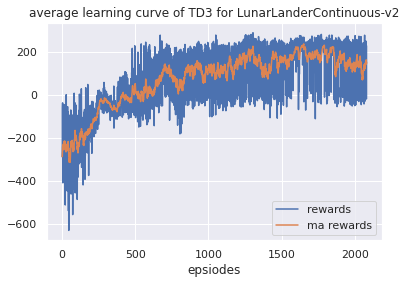

Start Evaluating!
20210828-014445
[20210828-014446: TD3] Episode:1: Frame:208.0: Reward:239.8
[20210828-014447: TD3] Episode:2: Frame:556.0: Reward:252.6
[20210828-014447: TD3] Episode:3: Frame:768.0: Reward:255.3
[20210828-014448: TD3] Episode:4: Frame:957.0: Reward:245.1
[20210828-014448: TD3] Episode:5: Frame:1181.0: Reward:261.6
[20210828-014449: TD3] Episode:6: Frame:1901.0: Reward:165.2
[20210828-014449: TD3] Episode:7: Frame:2627.0: Reward:188.9
[20210828-014449: TD3] Episode:8: Frame:2811.0: Reward:269.5
[20210828-014449: TD3] Episode:9: Frame:3003.0: Reward:256.4
[20210828-014452: TD3] Episode:10: Frame:4003.0: Reward:-44.4
[20210828-014454: TD3] Episode:11: Frame:5003.0: Reward:-30.3
[20210828-014454: TD3] Episode:12: Frame:5196.0: Reward:243.8
[20210828-014454: TD3] Episode:13: Frame:6196.0: Reward:-0.6
[20210828-014455: TD3] Episode:14: Frame:7196.0: Reward:-48.5
[20210828-014455: TD3] Episode:15: Frame:7411.0: Reward:249.6
[20210828-014455: TD3] Episode:16: Frame:7579.0: R

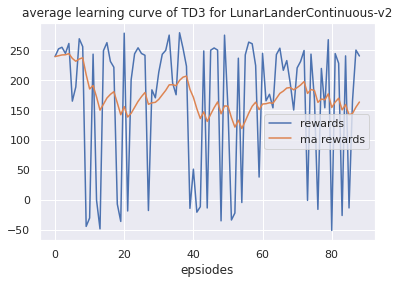

In [40]:
# 0.05, 0.1, 0.02
main()